# Auto-Encoder Based Data Clustering

https://link.springer.com/chapter/10.1007/978-3-642-41822-8_15

Apparently the way they initialize the cluster centroids is as follows:

* compute the mean of all INPUT IMAGES that are assigned to cluster c
* compute the embedded version of that using newly initialized autoencoder to get centroids

This does not seem right. It makes more sense to use the mean of the embedded vectors, not the input images. It seems that they at least do this for subsequent centroid updates, but I still do not know why they go against this idea for the initialization.

Source: https://github.com/developfeng/DeepClustering/blob/master/clustering/randinitial.m

Also, why would the loss term be minus the cluster loss? Shouldn't it be plus?

Description of experiment:

* a
* b

ToDo:
* split the centering and training into two separate loops -- slower, but it seems like the means move during training so breaks monotonicity of loss decreasing

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

from datasets import get_mnist_dataset, get_data_loader
from utils import *
from models import *

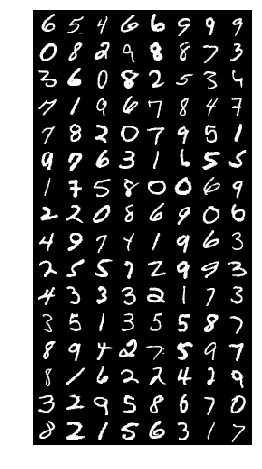

In [12]:
trainset, testset = get_mnist_dataset()
trainloader, testloader = get_data_loader(trainset, testset)
batch, labels = next(iter(trainloader))
plot_batch(batch)

In [13]:
class Encoder(nn.Module):
    
    def __init__(self, k):
        super().__init__()
#         self.fc1 = nn.Linear(784, 1000)
#         self.fc2 = nn.Linear(1000, 250)
        self.fc2 = nn.Linear(784, 250)
        self.fc3 = nn.Linear(250, 50)
        self.fc4 = nn.Linear(50, k)
    
    def forward(self, x):
        out = x.view(x.size(0), 784)
#         out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        return out

class Decoder(nn.Module):
    
    def __init__(self, k):
        super().__init__()
        self.fc1 = nn.Linear(k, 50)
        self.fc2 = nn.Linear(50, 250)
        self.fc3 = nn.Linear(250, 784)
#         self.fc3 = nn.Linear(250, 1000)
#         self.fc4 = nn.Linear(1000, 784)
    
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
#         out = F.relu(self.fc4(out))
        out = out.view(out.size(0), 1, 28, 28)
        return out

class KMeansCriterion(nn.Module):
    
    def __init__(self, lmbda):
        super().__init__()
        self.lmbda = lmbda
    
    def forward(self, embeddings, centroids):
        distances = torch.sum((embeddings[:, None, :] - centroids)**2, 2)
        cluster_distances, cluster_assignments = distances.max(1)
        loss = self.lmbda * cluster_distances.sum()
        return loss, cluster_assignments

In [14]:
def centroid_init(k, d):
    centroid_sums = Variable(torch.zeros(k, d))
    centroid_counts = Variable(torch.zeros(k))
    for X, y in trainloader:
        X_var, y_var = Variable(X), Variable(y)
        cluster_assignments = Variable(torch.LongTensor(X.size(0)).random_(k))
        embeddings = encoder(X_var)
        update_clusters(centroid_sums, centroid_counts,
                        cluster_assignments, embeddings)
    
    centroid_means = centroid_sums / centroid_counts[:, None]
    return centroid_means.clone()

def update_clusters(centroid_sums, centroid_counts,
                    cluster_assignments, embeddings):
    k = centroid_sums.size(0)
    centroid_sums.index_add_(0, cluster_assignments, embeddings)
    np_counts = np.bincount(cluster_assignments.data.numpy(), minlength=k)
    centroid_counts.add_(Variable(torch.FloatTensor(np_counts)))

def pretrain(autoencoder, optimizer,
             print_every=100, verbose=False):
    for i, (X, y) in enumerate(trainloader):
        X_var, y_var = Variable(X), Variable(y)
        X_hat = autoencoder(X_var)
        loss = F.mse_loss(X_hat, X_var)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if verbose and i % print_every == 0:
            batch_hat = autoencoder(Variable(batch))
            plot_batch(batch_hat.data)
            print('Trn Loss: %.3f' % loss.data[0])

def train(encoder, decoder, centroids, optimizer, criterion,
          print_every=100, verbose=False):
    k, d = centroids.size()
    centroid_sums = torch.zeros_like(centroids)
    centroid_counts = Variable(torch.zeros(k))
    
    # run one epoch of gradient descent on autoencoders wrt centroids
    for i, (X, y) in enumerate(trainloader):
        
        # forward pass and compute loss
        X_var, y_var = Variable(X), Variable(y)
        embeddings = encoder(X_var)
        X_hat = decoder(embeddings)
        recon_loss = F.mse_loss(X_hat, X_var)
        cluster_loss, cluster_assignments = criterion(embeddings, centroids)
        loss = recon_loss + cluster_loss
        
        # run update step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # store centroid sums and counts in memory for later centering
        update_clusters(centroid_sums, centroid_counts,
                        cluster_assignments, embeddings)
        
        if verbose and i % print_every == 0:
            batch_hat = autoencoder(Variable(batch))
            plot_batch(batch_hat.data)
            losses = (loss.data[0], recon_loss.data[0], cluster_loss.data[0])
            print('Trn Loss: %.3f [Recon Loss %.3f, Cluster Loss %.3f]' % losses)
    
    # update centroids based on assignments from autoencoders
    centroid_means = centroid_sums / (centroid_counts[:, None] + 1)
    return centroid_means, centroid_counts

def evaluate(encoder, decoder, loader):
    for X, y in loader:
        X_var, y_var = Variable(X), Variable(y)
        s = encoder(X_var)
        X_hat = decoder(s)
        # do something

In [15]:
k, d = 10, 10
encoder = Encoder(d)
decoder = Decoder(d)
autoencoder = nn.Sequential(encoder, decoder)
optimizer = optim.Adam(autoencoder.parameters())

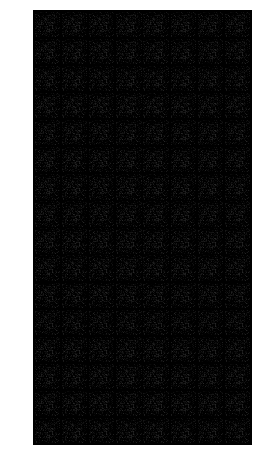

D:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Trn Loss: 0.105


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


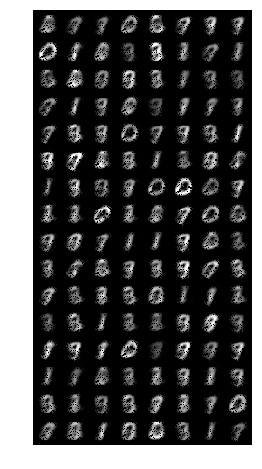

Trn Loss: 0.058


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


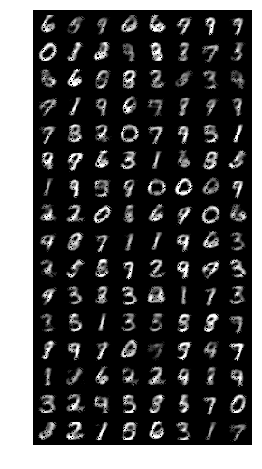

Trn Loss: 0.037


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


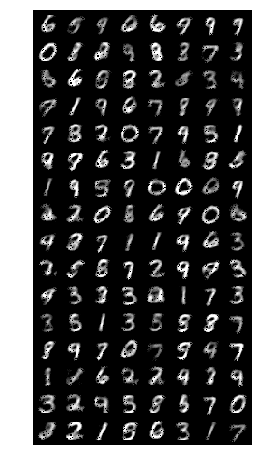

Trn Loss: 0.034


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


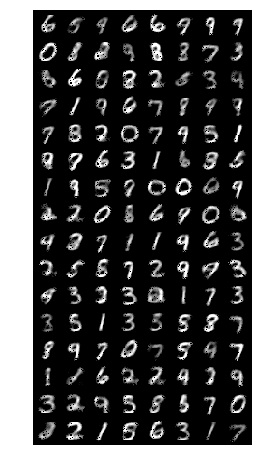

Trn Loss: 0.031


In [16]:
for _ in range(1):
    pretrain(autoencoder, optimizer, verbose=True)

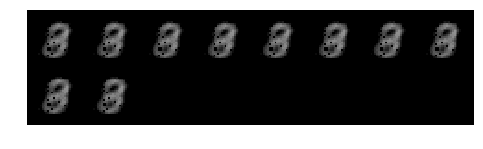

In [17]:
criterion = KMeansCriterion(lmbda=1e-3)
centroids = Variable(centroid_init(k, d).data)
plot_batch(decoder(centroids).data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


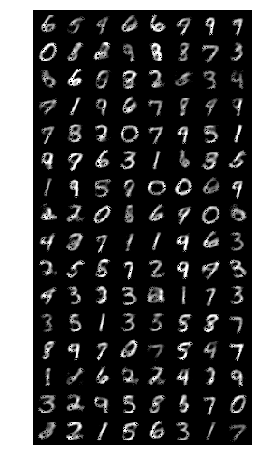

D:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Trn Loss: 2.164 [Recon Loss 0.032, Cluster Loss 2.132]


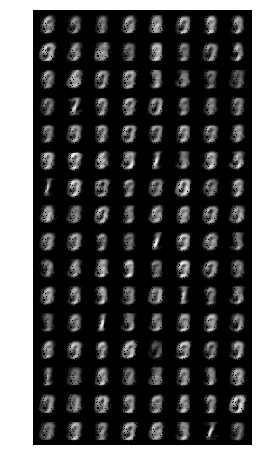

Trn Loss: 0.261 [Recon Loss 0.061, Cluster Loss 0.200]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


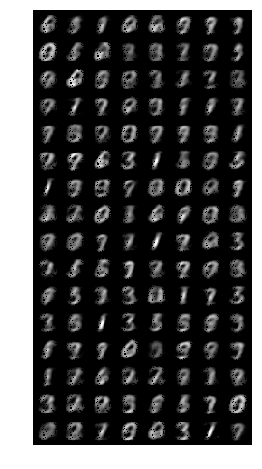

Trn Loss: 0.107 [Recon Loss 0.051, Cluster Loss 0.056]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


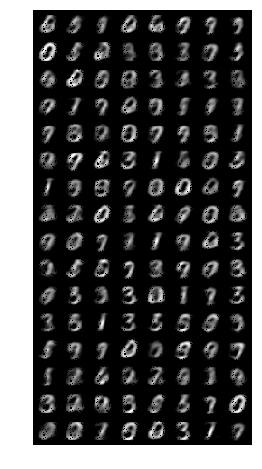

Trn Loss: 0.076 [Recon Loss 0.049, Cluster Loss 0.027]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


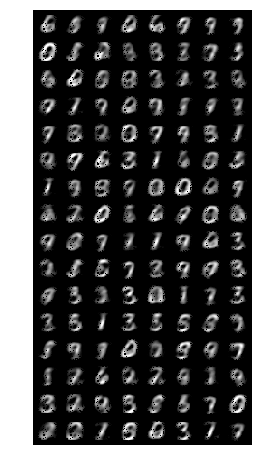

Trn Loss: 0.066 [Recon Loss 0.048, Cluster Loss 0.019]
[17101.0, 1949.0, 12379.0, 9980.0, 225.0, 647.0, 1468.0, 9774.0, 4851.0, 1626.0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


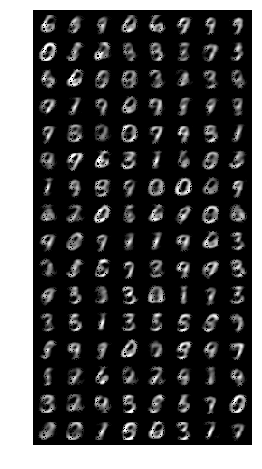

Trn Loss: 0.057 [Recon Loss 0.044, Cluster Loss 0.013]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


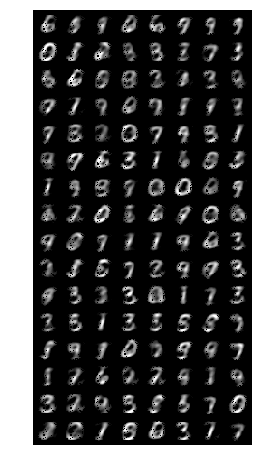

Trn Loss: 0.054 [Recon Loss 0.045, Cluster Loss 0.009]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


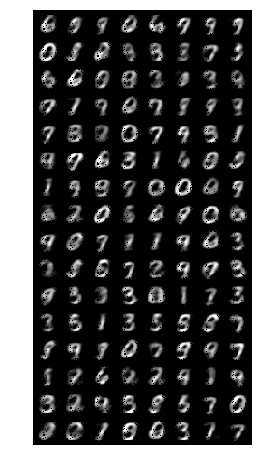

Trn Loss: 0.052 [Recon Loss 0.045, Cluster Loss 0.007]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


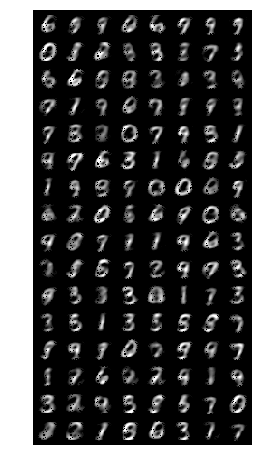

Trn Loss: 0.052 [Recon Loss 0.045, Cluster Loss 0.007]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


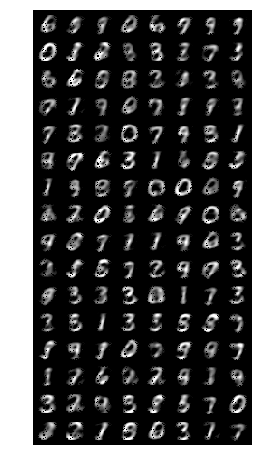

Trn Loss: 0.049 [Recon Loss 0.042, Cluster Loss 0.006]
[13843.0, 3954.0, 9965.0, 9678.0, 487.0, 2050.0, 3124.0, 5518.0, 8362.0, 3019.0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


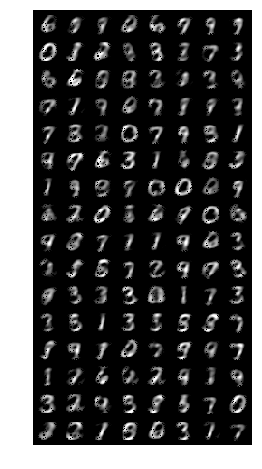

Trn Loss: 0.045 [Recon Loss 0.040, Cluster Loss 0.005]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


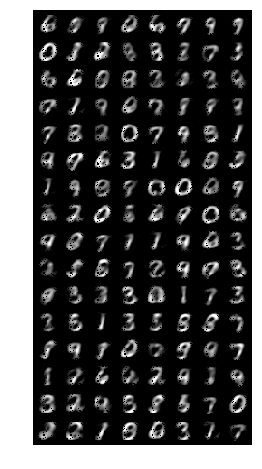

Trn Loss: 0.046 [Recon Loss 0.041, Cluster Loss 0.005]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


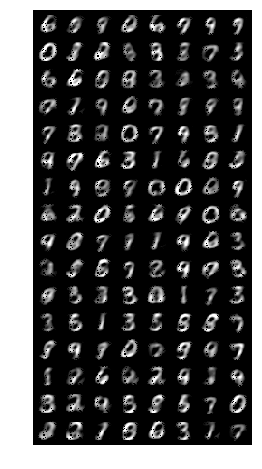

Trn Loss: 0.046 [Recon Loss 0.042, Cluster Loss 0.004]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


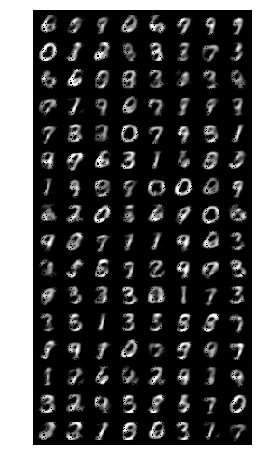

Trn Loss: 0.045 [Recon Loss 0.040, Cluster Loss 0.004]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


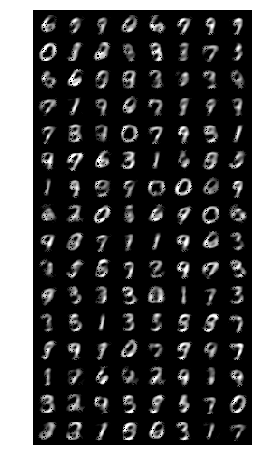

Trn Loss: 0.046 [Recon Loss 0.042, Cluster Loss 0.005]
[13399.0, 4246.0, 9382.0, 9410.0, 599.0, 2572.0, 3809.0, 4372.0, 8823.0, 3388.0]


In [18]:
for _ in range(3):
    centroid_means, centroid_counts = train(encoder, decoder, centroids, optimizer, criterion,
                                            verbose=True)
    print(centroid_counts.data.numpy().tolist())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


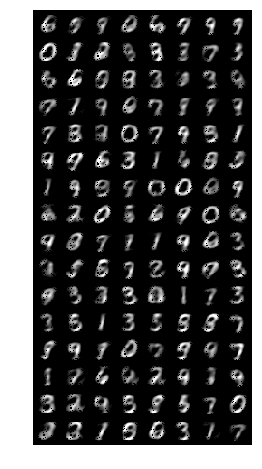

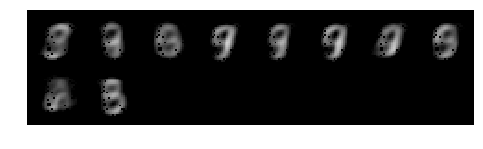

In [19]:
plot_batch(autoencoder(Variable(batch)).data)
plot_batch(decoder(centroids).data)